In [17]:
import numpy as np
import pandas as pd
from pathlib import Path
import os

_INPUT_DIR = Path("kaggle/input")
_WORKING_DIR = Path('kaggle/working')
_WORKING_DIR.mkdir(exist_ok=True)

import zipfile
with zipfile.ZipFile(_INPUT_DIR /'plates.zip', 'r') as zip_obj:
   zip_obj.extractall(_WORKING_DIR)

_DATA_ROOT = _WORKING_DIR / 'plates'

In [21]:
import shutil 
from tqdm import tqdm

_TRAIN_DIR = _WORKING_DIR / 'train'
_VAL_DIR = _WORKING_DIR / 'val'

_CLASSES = ['cleaned', 'dirty']

for dir_name in [_TRAIN_DIR, _VAL_DIR]:
    for class_name in _CLASSES:
        (dir_name / class_name).mkdir(parents=True, exist_ok=True)

for class_name in _CLASSES:
    source_dir = _DATA_ROOT / 'train' / class_name
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = _TRAIN_DIR / class_name
        else:
            dest_dir = _VAL_DIR / class_name
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 10192.13it/s]


In [65]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models

_NORM_MEANS = [0.485, 0.456, 0.406]
_NORM_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.4, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAutocontrast(),
    transforms.RandomEqualize(),
    transforms.ToTensor(),
    transforms.Normalize(_NORM_MEANS, _NORM_STD)
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(_NORM_MEANS, _NORM_STD)
])

train_dataset = torchvision.datasets.ImageFolder(_TRAIN_DIR, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(_VAL_DIR, val_transforms)

_BATCH_SIZE = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=_BATCH_SIZE, shuffle=True, num_workers=_BATCH_SIZE)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=_BATCH_SIZE, shuffle=False, num_workers=_BATCH_SIZE)

In [66]:
len(train_dataloader), len(train_dataset)

(4, 32)

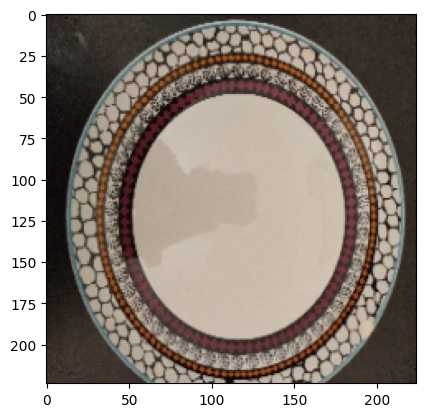

In [56]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array(_NORM_MEANS)
std = np.array(_NORM_STD)
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

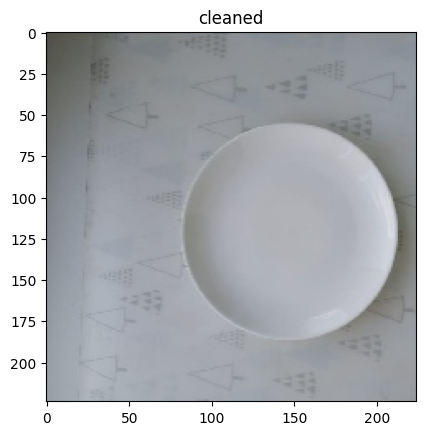

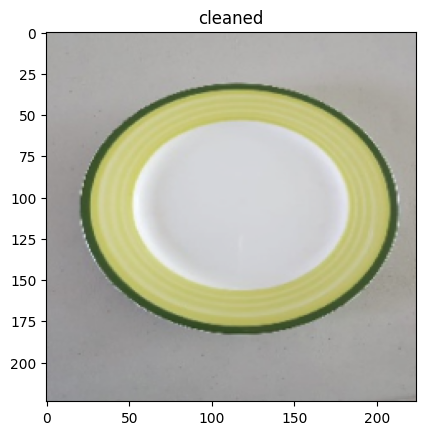

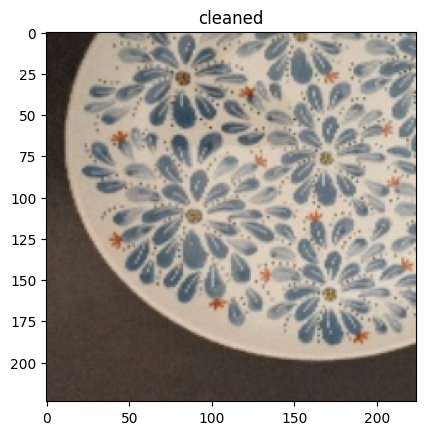

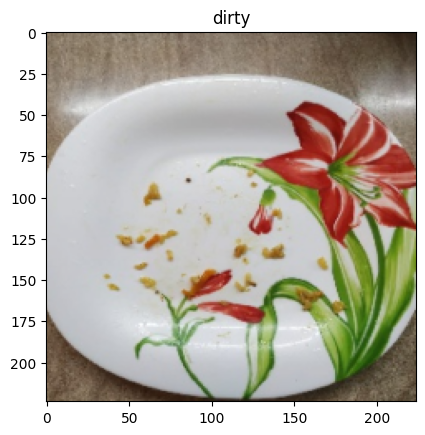

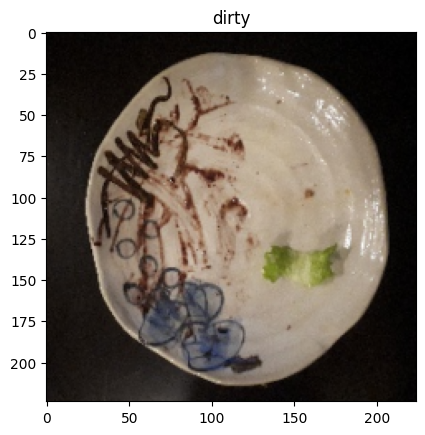

In [57]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=_CLASSES[y_item])

In [67]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [80]:
#model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
# for param in model.parameters():
#     param.requires_grad = False

# model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1.0e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [81]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.74it/s]

train Loss: 0.3592 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]

val Loss: 0.3802 Acc: 0.8750
Epoch 1/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.91it/s]

train Loss: 0.3314 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.3770 Acc: 0.8750
Epoch 2/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.67it/s]

train Loss: 0.3255 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

val Loss: 0.3853 Acc: 0.7500
Epoch 3/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.62it/s]

train Loss: 0.3490 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]

val Loss: 0.3877 Acc: 0.7500
Epoch 4/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.91it/s]

train Loss: 0.4150 Acc: 0.7812



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

val Loss: 0.3941 Acc: 0.7500
Epoch 5/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.03it/s]

train Loss: 0.3372 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

val Loss: 0.3984 Acc: 0.7500
Epoch 6/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.88it/s]

train Loss: 0.3774 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]

val Loss: 0.4096 Acc: 0.7500
Epoch 7/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]

train Loss: 0.3847 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

val Loss: 0.3903 Acc: 0.7500
Epoch 8/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.10it/s]

train Loss: 0.5179 Acc: 0.7500



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]

val Loss: 0.3703 Acc: 0.8750
Epoch 9/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.19it/s]

train Loss: 0.3192 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]

val Loss: 0.3644 Acc: 0.8750
Epoch 10/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.10it/s]

train Loss: 0.3589 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]

val Loss: 0.3811 Acc: 0.8750
Epoch 11/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.61it/s]

train Loss: 0.3647 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]

val Loss: 0.3786 Acc: 0.8750
Epoch 12/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.79it/s]

train Loss: 0.4488 Acc: 0.7812



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]

val Loss: 0.3787 Acc: 0.7500
Epoch 13/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.40it/s]

train Loss: 0.3896 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 0.3825 Acc: 0.7500
Epoch 14/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.34it/s]

train Loss: 0.4013 Acc: 0.8125



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 0.3870 Acc: 0.7500
Epoch 15/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.81it/s]

train Loss: 0.4363 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]

val Loss: 0.3925 Acc: 0.7500
Epoch 16/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.10it/s]

train Loss: 0.4155 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]

val Loss: 0.3898 Acc: 0.7500
Epoch 17/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.43it/s]

train Loss: 0.4377 Acc: 0.7812



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]

val Loss: 0.3945 Acc: 0.7500
Epoch 18/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.86it/s]

train Loss: 0.3543 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]

val Loss: 0.4053 Acc: 0.7500
Epoch 19/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.97it/s]

train Loss: 0.3397 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

val Loss: 0.4013 Acc: 0.7500
Epoch 20/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.22it/s]

train Loss: 0.3920 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]

val Loss: 0.3834 Acc: 0.7500
Epoch 21/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.40it/s]

train Loss: 0.3732 Acc: 0.7812



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]

val Loss: 0.3706 Acc: 0.7500
Epoch 22/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.85it/s]

train Loss: 0.3698 Acc: 0.8125



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]

val Loss: 0.3557 Acc: 0.8750
Epoch 23/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.25it/s]

train Loss: 0.2802 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]

val Loss: 0.3578 Acc: 0.8750
Epoch 24/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.44it/s]

train Loss: 0.3413 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.3697 Acc: 0.7500
Epoch 25/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.64it/s]

train Loss: 0.3129 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]

val Loss: 0.3827 Acc: 0.7500
Epoch 26/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.26it/s]

train Loss: 0.3031 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]

val Loss: 0.3740 Acc: 0.7500
Epoch 27/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.98it/s]

train Loss: 0.3803 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

val Loss: 0.3660 Acc: 0.7500
Epoch 28/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.46it/s]

train Loss: 0.3963 Acc: 0.7812



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]

val Loss: 0.3689 Acc: 0.7500
Epoch 29/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.44it/s]

train Loss: 0.3555 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]

val Loss: 0.3730 Acc: 0.7500
Epoch 30/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.43it/s]

train Loss: 0.3215 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

val Loss: 0.3894 Acc: 0.7500
Epoch 31/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]

train Loss: 0.3160 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]

val Loss: 0.3902 Acc: 0.7500
Epoch 32/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.13it/s]

train Loss: 0.3340 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]

val Loss: 0.3994 Acc: 0.7500
Epoch 33/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]

train Loss: 0.3562 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.33it/s]

val Loss: 0.3849 Acc: 0.7500
Epoch 34/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.79it/s]

train Loss: 0.3246 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]

val Loss: 0.3915 Acc: 0.7500
Epoch 35/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.56it/s]

train Loss: 0.4116 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]

val Loss: 0.3838 Acc: 0.7500
Epoch 36/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.35it/s]

train Loss: 0.3988 Acc: 0.8125



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]

val Loss: 0.3869 Acc: 0.7500
Epoch 37/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.70it/s]

train Loss: 0.4531 Acc: 0.7500



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]

val Loss: 0.3693 Acc: 0.8750
Epoch 38/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.87it/s]

train Loss: 0.4857 Acc: 0.7812



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.48it/s]

val Loss: 0.3851 Acc: 0.7500
Epoch 39/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.36it/s]

train Loss: 0.3511 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

val Loss: 0.3742 Acc: 0.7500
Epoch 40/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.79it/s]

train Loss: 0.3195 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]

val Loss: 0.3700 Acc: 0.8750
Epoch 41/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.90it/s]

train Loss: 0.4339 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]

val Loss: 0.3634 Acc: 0.8750
Epoch 42/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]

train Loss: 0.3164 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]

val Loss: 0.3687 Acc: 0.7500
Epoch 43/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.35it/s]

train Loss: 0.3279 Acc: 0.9688



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]

val Loss: 0.3676 Acc: 0.7500
Epoch 44/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.52it/s]

train Loss: 0.3189 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

val Loss: 0.3691 Acc: 0.8750
Epoch 45/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.77it/s]

train Loss: 0.3205 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

val Loss: 0.3664 Acc: 0.7500
Epoch 46/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.68it/s]

train Loss: 0.3270 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

val Loss: 0.3670 Acc: 0.7500
Epoch 47/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.62it/s]

train Loss: 0.3428 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

val Loss: 0.3571 Acc: 0.8750
Epoch 48/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.74it/s]

train Loss: 0.3751 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]

val Loss: 0.3751 Acc: 0.7500
Epoch 49/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.27it/s]

train Loss: 0.2898 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

val Loss: 0.3721 Acc: 0.7500
Epoch 50/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.23it/s]

train Loss: 0.3193 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

val Loss: 0.3819 Acc: 0.7500
Epoch 51/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.10it/s]

train Loss: 0.3057 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]

val Loss: 0.3788 Acc: 0.7500
Epoch 52/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.04it/s]

train Loss: 0.2892 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]

val Loss: 0.3800 Acc: 0.7500
Epoch 53/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.94it/s]

train Loss: 0.2842 Acc: 0.9688



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]

val Loss: 0.3840 Acc: 0.7500
Epoch 54/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.89it/s]

train Loss: 0.3756 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

val Loss: 0.3866 Acc: 0.7500
Epoch 55/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.64it/s]

train Loss: 0.3907 Acc: 0.7812



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]

val Loss: 0.3900 Acc: 0.7500
Epoch 56/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.52it/s]

train Loss: 0.3069 Acc: 0.9688



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

val Loss: 0.3916 Acc: 0.7500
Epoch 57/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.03it/s]

train Loss: 0.2586 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]

val Loss: 0.3839 Acc: 0.7500
Epoch 58/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.82it/s]

train Loss: 0.3195 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 0.3813 Acc: 0.7500
Epoch 59/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.49it/s]

train Loss: 0.3066 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]

val Loss: 0.3827 Acc: 0.7500
Epoch 60/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.11it/s]

train Loss: 0.3439 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

val Loss: 0.3753 Acc: 0.7500
Epoch 61/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.58it/s]

train Loss: 0.3267 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]

val Loss: 0.3836 Acc: 0.7500
Epoch 62/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.31it/s]

train Loss: 0.3574 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]

val Loss: 0.3858 Acc: 0.7500
Epoch 63/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.09it/s]

train Loss: 0.2648 Acc: 0.9688



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 0.3883 Acc: 0.7500
Epoch 64/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.49it/s]

train Loss: 0.3502 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.86it/s]

val Loss: 0.3820 Acc: 0.7500
Epoch 65/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.01it/s]

train Loss: 0.4233 Acc: 0.7812



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]

val Loss: 0.3659 Acc: 0.7500
Epoch 66/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.79it/s]

train Loss: 0.3572 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]

val Loss: 0.3541 Acc: 0.7500
Epoch 67/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.63it/s]

train Loss: 0.4044 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

val Loss: 0.3446 Acc: 0.8750
Epoch 68/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.37it/s]

train Loss: 0.3883 Acc: 0.8125



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]

val Loss: 0.3667 Acc: 0.7500
Epoch 69/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.12it/s]

train Loss: 0.3284 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]

val Loss: 0.3797 Acc: 0.7500
Epoch 70/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.96it/s]

train Loss: 0.3053 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]

val Loss: 0.3746 Acc: 0.7500
Epoch 71/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.33it/s]

train Loss: 0.2705 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]

val Loss: 0.3782 Acc: 0.7500
Epoch 72/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.61it/s]

train Loss: 0.3681 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]

val Loss: 0.3818 Acc: 0.7500
Epoch 73/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.28it/s]

train Loss: 0.3198 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]

val Loss: 0.3703 Acc: 0.7500
Epoch 74/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]

train Loss: 0.4417 Acc: 0.8125



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]

val Loss: 0.3737 Acc: 0.7500
Epoch 75/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.07it/s]

train Loss: 0.3808 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]

val Loss: 0.3776 Acc: 0.7500
Epoch 76/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.04it/s]

train Loss: 0.3394 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

val Loss: 0.3610 Acc: 0.7500
Epoch 77/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.23it/s]

train Loss: 0.3701 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]

val Loss: 0.3709 Acc: 0.7500
Epoch 78/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.88it/s]

train Loss: 0.3099 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]

val Loss: 0.3763 Acc: 0.7500
Epoch 79/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.91it/s]

train Loss: 0.3350 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]

val Loss: 0.3839 Acc: 0.7500
Epoch 80/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.18it/s]

train Loss: 0.3297 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

val Loss: 0.3691 Acc: 0.7500
Epoch 81/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.06it/s]

train Loss: 0.3435 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

val Loss: 0.3727 Acc: 0.7500
Epoch 82/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]

train Loss: 0.2880 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]

val Loss: 0.3799 Acc: 0.7500
Epoch 83/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.09it/s]

train Loss: 0.3390 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]

val Loss: 0.3718 Acc: 0.7500
Epoch 84/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.98it/s]

train Loss: 0.3307 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.45it/s]

val Loss: 0.3636 Acc: 0.7500
Epoch 85/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.95it/s]

train Loss: 0.4581 Acc: 0.7812



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]

val Loss: 0.3699 Acc: 0.7500
Epoch 86/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.69it/s]

train Loss: 0.3535 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.87it/s]

val Loss: 0.3721 Acc: 0.7500
Epoch 87/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.29it/s]

train Loss: 0.3744 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

val Loss: 0.3692 Acc: 0.7500
Epoch 88/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.17it/s]

train Loss: 0.2919 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]

val Loss: 0.3578 Acc: 0.7500
Epoch 89/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.34it/s]

train Loss: 0.3150 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

val Loss: 0.3620 Acc: 0.7500
Epoch 90/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.51it/s]

train Loss: 0.4074 Acc: 0.8125



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

val Loss: 0.3842 Acc: 0.7500
Epoch 91/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.57it/s]

train Loss: 0.3783 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

val Loss: 0.3838 Acc: 0.7500
Epoch 92/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.30it/s]

train Loss: 0.3086 Acc: 0.9688



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]

val Loss: 0.3744 Acc: 0.7500
Epoch 93/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.34it/s]

train Loss: 0.2790 Acc: 0.9375



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]

val Loss: 0.3608 Acc: 0.7500
Epoch 94/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.05it/s]

train Loss: 0.3825 Acc: 0.7812



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]

val Loss: 0.3687 Acc: 0.7500
Epoch 95/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.55it/s]

train Loss: 0.3991 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

val Loss: 0.3653 Acc: 0.7500
Epoch 96/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.32it/s]

train Loss: 0.3289 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]

val Loss: 0.3781 Acc: 0.7500
Epoch 97/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.02it/s]

train Loss: 0.3387 Acc: 0.8750



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]

val Loss: 0.3823 Acc: 0.7500
Epoch 98/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.25it/s]

train Loss: 0.3558 Acc: 0.9062



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]

val Loss: 0.3758 Acc: 0.7500
Epoch 99/99:



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.70it/s]

train Loss: 0.3635 Acc: 0.8438



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]

val Loss: 0.3715 Acc: 0.7500


In [33]:
_TEST_DIR = _WORKING_DIR / 'test'
shutil.copytree(_DATA_ROOT / 'test', _TEST_DIR / 'unknown')

PosixPath('kaggle/working/test/unknown')

In [34]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(_TEST_DIR, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=_BATCH_SIZE, shuffle=False, num_workers=0)

In [35]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: kaggle/working/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [82]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:01<00:00, 52.62it/s]


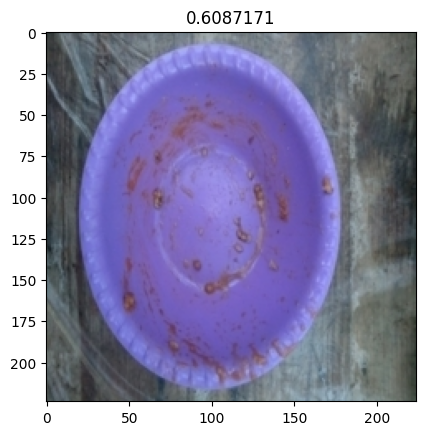

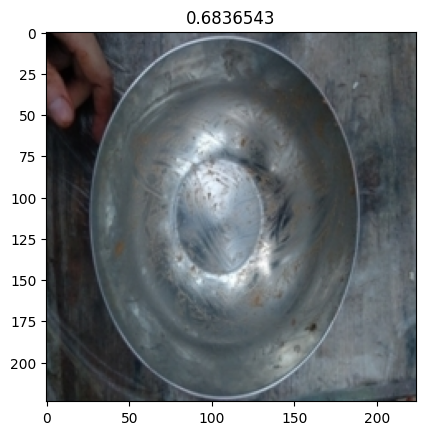

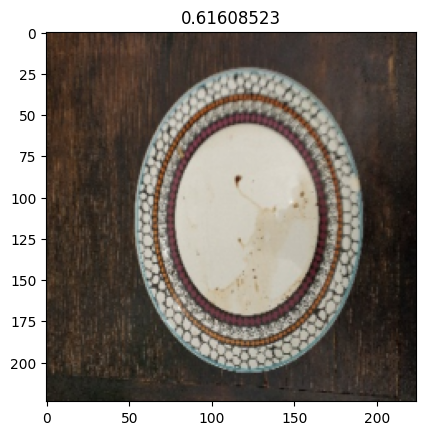

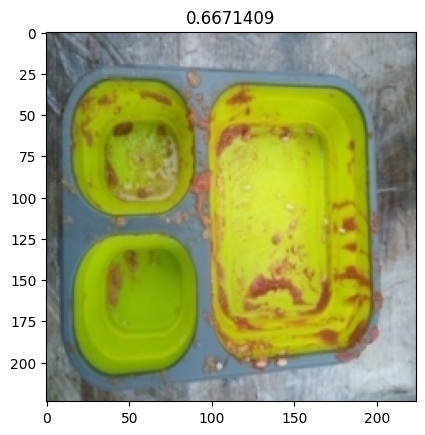

In [37]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [83]:
submission_df = pd.DataFrame.from_dict({'id': [Path(p).stem for p in test_img_paths], 'label': test_predictions})

In [84]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id           
0000    dirty
0001    dirty
0002  cleaned
0003    dirty
0004    dirty
0005    dirty

In [85]:
submission_df.to_csv('submission.csv')

In [ ]:
!rm -rf train val test